# Project: Basketball

Author: Minh Bui
<br>
Class: CSCI 3022

Source: https://www.kaggle.com/datasets/ionaskel/nba-games-stats-from-2014-to-2018?resource=download

## The 3 Point Revolution

My multivariate analysis problem involves 3 point shooting in the NBA and how it impacts winning percentage.  This problem is of great interest to me because I love basketball, and I feel that 3 pointers have changed the way the game is played.  The problem is a regression task, as I hope to use 3 point shooting statistics as a predictive measure of wins and losses in the NBA.  I took data from the NBA seasons between 2014-2018 because these years represented the Golden State Warriors dynasty.  The link to my data source is provided above and it details basketball statistics for every NBA team during the designated timeframe.  The dataset contains 41 columns designating different statistical categories.  The total number of rows is 9840 which represents the total amount of games played during our timeline.  30 teams times 82 games multiplied by 4 seasons equals 9840 rows of data.

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy import random
import seaborn as sns; sns.set()
import scipy as sp
import scipy.stats as stats
import math
import statsmodels.formula.api as smf
import statsmodels.api as sm
import patsy
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier

In [2]:
nba = pd.read_csv('nba.games.stats.csv')
nba

,Unnamed: 0,Team,Game,Date,Home,Opponent,WINorLOSS,TeamPoints,OpponentPoints,FieldGoals,...,Opp.FreeThrows,Opp.FreeThrowsAttempted,Opp.FreeThrows.,Opp.OffRebounds,Opp.TotalRebounds,Opp.Assists,Opp.Steals,Opp.Blocks,Opp.Turnovers,Opp.TotalFouls
0,1,ATL,1,10/29/2014,Away,TOR,L,102,109,40,...,27,33,0.818,16,48,26,13,9,9,22
1,2,ATL,2,11/1/2014,Home,IND,W,102,92,35,...,18,21,0.857,11,44,25,5,5,18,26
2,3,ATL,3,11/5/2014,Away,SAS,L,92,94,38,...,27,38,0.711,11,50,25,7,9,19,15
3,4,ATL,4,11/7/2014,Away,CHO,L,119,122,43,...,20,27,0.741,11,51,31,6,7,19,30
4,5,ATL,5,11/8/2014,Home,NYK,W,103,96,33,...,8,11,0.727,13,44,26,2,6,15,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9835,78119,WAS,78,4/3/2018,Away,HOU,L,104,120,38,...,18,27,0.667,10,46,26,13,3,9,14
9836,79119,WAS,79,4/5/2018,Away,CLE,L,115,119,47,...,22,28,0.786,5,35,26,10,3,16,14
9837,80119,WAS,80,4/6/2018,Home,ATL,L,97,103,35,...,16,23,0.696,7,50,24,5,5,18,22
9838,81124,WAS,81,4/10/2018,Home,BOS,W,113,101,41,...,22,27,0.815,13,44,22,14,1,16,18


## Season by Season Analysis

The success of teams like the Golden State Warriors caused franchises accross the entire league to place a greater emphasis on 3 point shooting.  Every year from 2014-2018 saw increases in every 3 point statistic throughout the whole NBA.  The table below shows that each season saw a league wide increase in total 3 point makes, attempts, and shooting percentage.

In [3]:
season_length = nba.shape[0] / 4
seasons = []

for i in range(4):
    seasons.append(nba.loc[season_length * i: season_length * (i + 1) - 1])
    
year = {
    '2014-2015': seasons[0].sum(),
    '2015-2016': seasons[1].sum(),
    '2016-2017': seasons[2].sum(),
    '2017-2018': seasons[3].sum()
}

In [4]:
seasonDB = pd.DataFrame(columns = ['3 Point Makes', '3 Point Attempts'])

for season in year:
    seasonDB.loc[seasonDB.shape[0]] = [
        year[season].loc['X3PointShots'],
        year[season].loc['X3PointShotsAttempted']
    ]

seasonDB.insert(0, 'Season', year.keys())
seasonDB['3 Point Percentage'] = (
    seasonDB['3 Point Makes'] / seasonDB['3 Point Attempts'] * 100
)

seasonDB

,Season,3 Point Makes,3 Point Attempts,3 Point Percentage
0,2014-2015,19300,55137,35.003718
1,2015-2016,20953,59241,35.369086
2,2016-2017,23748,66422,35.753214
3,2017-2018,25807,71337,36.176178


## Data Cleanup

The original dataset includes several columns that do not pertain to game stats, such as Date, Home, and Opponent, so I excluded them from my database.  I cleaned up the data by creating a new dataframe from all the relevant statistics in the original database.  I did this by grouping the data by team name and transforming every win into a 1 and all losses into 0.  By summing up the win/loss column, I got the win total for every team from 2014-2018.  Win rate is calculated as team wins divided by total games played.  Percentage values (Field Goals, 3 Pointers, and Free Throws) were all calculated as Shots Made divided by Shots Attempted.  Defensive rebounding was not included in the original data, so I calculated it as Total Rebounds minus Offensive Rebounds.

In [5]:
nba.insert(7, 'Wins', nba['WINorLOSS'].eq('W'))
nba['Wins'] = nba['Wins'].astype(int)

removed_col = [
    'Unnamed: 0', 
    'Game', 
    'Date', 
    'Home', 
    'Opponent', 
    'WINorLOSS',
    'FieldGoals.', 
    'X3PointShots.', 
    'FreeThrows.', 
    'Opp.FieldGoals.',
    'Opp.3PointShots.',
    'Opp.FreeThrows.'
]

nba = nba.drop(removed_col, axis = 1)

defReb = nba['TotalRebounds'] - nba['OffRebounds']
nba.insert(11, 'Def Rebounds', defReb)

defRebOpp = nba['Opp.TotalRebounds'] - nba['Opp.OffRebounds']
nba.insert(25, 'Opp Def Rebounds', defRebOpp)

In [6]:
def buildDB(data):
    dfNBA = pd.DataFrame(data)
    dfNBA = dfNBA.groupby(['Team'])
    dfNBA = dfNBA.sum()
        
    total = data['Team'].value_counts()
    losses = total - dfNBA['Wins']
    winRate = dfNBA['Wins'] / total
    
    dfNBA.insert(1, 'Losses', losses)
    dfNBA.insert(2, 'Winning Percentage', winRate * 100)
    
    fgPerc = dfNBA['FieldGoals'] / dfNBA['FieldGoalsAttempted']
    dfNBA.insert(7, 'Field Goal Percentage', fgPerc * 100)

    perc3pt = dfNBA['X3PointShots'] / dfNBA['X3PointShotsAttempted']
    dfNBA.insert(10, '3 Point Percentage', perc3pt * 100)

    ftPerc = dfNBA['FreeThrows'] / dfNBA['FreeThrowsAttempted']
    dfNBA.insert(13, 'Free Throw Percentage', ftPerc * 100)
    
    fgPercOpp = dfNBA['Opp.FieldGoals'] / dfNBA['Opp.FieldGoalsAttempted']
    dfNBA.insert(24, 'Opp Field Goal Percentage', fgPercOpp * 100)

    perc3ptOpp = dfNBA['Opp.3PointShots'] / dfNBA['Opp.3PointShotsAttempted']
    dfNBA.insert(27, 'Opp 3 Point Percentage', perc3ptOpp * 100)

    ftPercOpp = dfNBA['Opp.FreeThrows'] / dfNBA['Opp.FreeThrowsAttempted']
    dfNBA.insert(30, 'Opp Free Throw Percentage', ftPercOpp * 100)

    return dfNBA

In [7]:
dfNBA = buildDB(nba)
dfNBA

,Wins,Losses,Winning Percentage,TeamPoints,OpponentPoints,FieldGoals,FieldGoalsAttempted,Field Goal Percentage,X3PointShots,X3PointShotsAttempted,...,Opp.FreeThrowsAttempted,Opp Free Throw Percentage,Opp.OffRebounds,Opp Def Rebounds,Opp.TotalRebounds,Opp.Assists,Opp.Steals,Opp.Blocks,Opp.Turnovers,Opp.TotalFouls
Team,,,,,,,,,,,,,,,,,,,,,
ATL,175,153,53.353659,33776,33552,12542,27554,45.517892,3279,9159,...,6806,76.535410,3609,11007,14616,7794,2758,1692,4938,6540
BOS,196,132,59.756098,34367,33581,12718,28482,44.652763,3301,9397,...,7835,76.056158,3499,11183,14682,7108,2422,1670,4702,6498
BRK,107,221,32.621951,33541,35239,12443,27825,44.718778,2990,8656,...,7326,75.853126,3532,11364,14896,7620,2773,1709,4217,6437
CHI,160,168,48.780488,33475,33892,12505,28394,44.040995,2825,7959,...,6751,76.018368,3466,11147,14613,7567,2459,1710,4004,6238
CHO,153,175,46.646341,33675,33675,12239,27960,43.773247,3019,8556,...,6398,77.743045,2878,11628,14506,7757,2135,1742,4148,6849
CLE,211,117,64.329268,35150,33954,12846,27540,46.644880,3754,10096,...,6716,75.387135,3359,10581,13940,7876,2443,1419,4141,6761
DAL,149,179,45.426829,33435,33711,12415,27726,44.777465,3383,9585,...,7334,75.470412,3326,11614,14940,7302,2349,1324,4657,6769
DEN,149,179,45.426829,34856,35238,12907,28457,45.356151,3126,8876,...,7631,75.743677,3268,10687,13955,7819,2606,1816,4237,6762
DET,152,176,46.341463,33256,33392,12629,28536,44.256378,2960,8479,...,6700,77.761194,3014,11197,14211,7708,2303,1494,4313,6302


In [8]:
def CleanData(data):
    clean = data
    
    for col in clean:
        if 'Opp' in col:
            clean = clean.drop(col, axis = 1)

    fgPerc = clean['FieldGoals'] / clean['FieldGoalsAttempted']
    clean.insert(5, 'Field Goal Percentage', fgPerc * 100)

    perc3pt = clean['X3PointShots'] / clean['X3PointShotsAttempted']
    clean.insert(8, '3 Point Percentage', perc3pt * 100)

    ftPerc = clean['FreeThrows'] / clean['FreeThrowsAttempted']
    clean.insert(11, 'Free Throw Percentage', ftPerc * 100)

    clean = clean.set_index('Team')
    return clean

In [9]:
cleanNBA = CleanData(nba)
cleanNBA

,Wins,TeamPoints,FieldGoals,FieldGoalsAttempted,Field Goal Percentage,X3PointShots,X3PointShotsAttempted,3 Point Percentage,FreeThrows,FreeThrowsAttempted,Free Throw Percentage,OffRebounds,Def Rebounds,TotalRebounds,Assists,Steals,Blocks,Turnovers,TotalFouls
Team,,,,,,,,,,,,,,,,,,,
ATL,0,102,40,80,50.000000,13,22,59.090909,9,17,52.941176,10,32,42,26,6,8,17,24
ATL,1,102,35,69,50.724638,7,20,35.000000,25,33,75.757576,3,34,37,26,10,6,12,20
ATL,0,92,38,92,41.304348,8,25,32.000000,8,11,72.727273,10,27,37,26,14,5,13,25
ATL,0,119,43,93,46.236559,13,33,39.393939,20,26,76.923077,7,31,38,28,8,3,19,33
ATL,1,103,33,81,40.740741,9,22,40.909091,28,36,77.777778,12,29,41,18,10,5,8,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WAS,0,104,38,72,52.777778,12,25,48.000000,16,23,69.565217,3,33,36,25,6,1,17,21
WAS,0,115,47,94,50.000000,9,21,42.857143,12,14,85.714286,12,29,41,34,8,7,15,23
WAS,0,97,35,87,40.229885,9,25,36.000000,18,23,78.260870,9,36,45,18,8,4,12,15


## Exploratory Data Analysis

My exploratory data analysis prints graphs of every team’s win/loss record, 3 point makes vs attempts, and 3 point shooting percentage vs winning percentage.  The teams of greatest interest are GSW, CLE, SAS, and HOU.  The Warriors won 3 of the 4 championships during the 2014-2018 timeline, and they did it by shooting a higher 3 point percentage than any other team in the NBA.  Cleveland was the only team to beat Golden State in the NBA Finals, and the Cavaliers had the second highest recorded 3 point shooting rate.  The San Antonio Spurs yielded the second best regular season winning percentage behind Golden State, and the Spurs had the third best 3 point shooting percentage.  Houston was the only team that shot and made more 3 pointers than the Warriors, but their shooting percentage was lower so their Win/Loss record was inferior.

[Text(0, 0.5, 'Win Loss Record')]

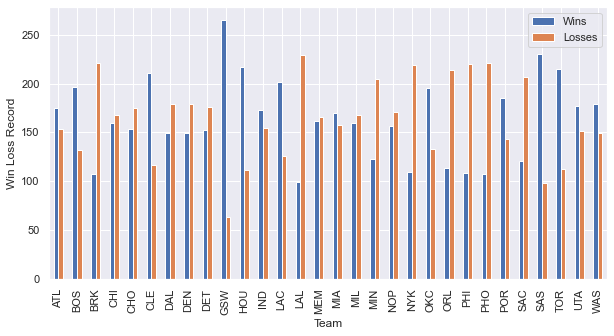

In [10]:
dfNBA[['Wins', 'Losses']].plot(kind='bar', figsize=(10, 5)).set(ylabel = 'Win Loss Record')

[Text(0, 0.5, '3 Point Shooting')]

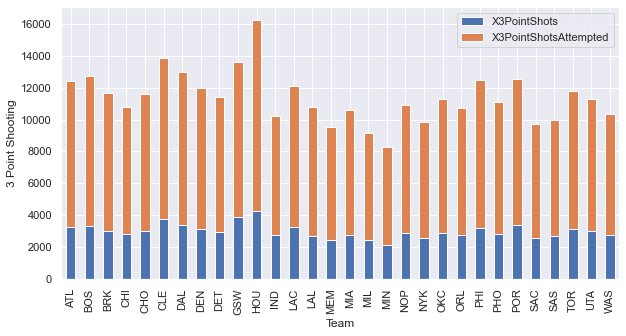

In [11]:
dfNBA[['X3PointShots', 'X3PointShotsAttempted']].plot(kind='bar', stacked=True, figsize=(10, 5)).set(ylabel = '3 Point Shooting')

[Text(0, 0.5, '3 Pointer Winning Percentage')]

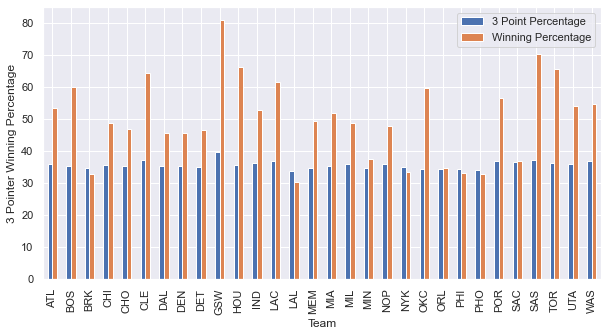

In [12]:
dfNBA[['3 Point Percentage', 'Winning Percentage']].plot(kind='bar', figsize=(10, 5)).set(ylabel = '3 Pointer Winning Percentage')

## Statistical Correlations

Below are correlation matrices, a heatmap, and scatter plots that all demonstrate the correlations between Win Rate and every statistical category in the database.  The first correlation matrix is sorted by highest correlation value in relation to Win Total.  The second matrix is sorted in the same order, but with absolute values for all negative correlations.  This allows us to gauge the importance of defensive stats, such as Opponents' Points Scored and Shooting Percentage.

The results of these correlation matrices shows that 3 Point Percentage has the strongest correlative relationship with winning.  The second matrix shows that the second strongest correlation is a defensive stat: Opponent's Field Goal Percentage.  This is followed closely by Team Points and your own Field Goal Percentage.  All of this makes sense, because limiting the other team's shooting rate while scoring a lot of points yourself, will obviously lead to victory.  3 Point Percentage yielded an even higher correlation score than these vital stats, which means accurate 3 Point Shooting gives you the best chance to win.

A heatmap display visualizes the correlation between every combination of stats in the entire database.  Scatter plots show the correlation between Winning Percentage and all other stats, besides Wins and Losses.  You can see from these graphs that 3 Point Shooting Percentage yields the straightest, most linearly positive relationship with Win Rate.

In [13]:
corr_matrix = dfNBA.corr()
corr_matrix.sort_values('Wins', ascending=False)

,Wins,Losses,Winning Percentage,TeamPoints,OpponentPoints,FieldGoals,FieldGoalsAttempted,Field Goal Percentage,X3PointShots,X3PointShotsAttempted,...,Opp.FreeThrowsAttempted,Opp Free Throw Percentage,Opp.OffRebounds,Opp Def Rebounds,Opp.TotalRebounds,Opp.Assists,Opp.Steals,Opp.Blocks,Opp.Turnovers,Opp.TotalFouls
Wins,1.000000,-1.000000,1.000000,0.691027,-0.565639,0.570585,-0.095035,0.684257,0.561220,0.409296,...,-0.225099,-0.194457,0.029355,-0.473609,-0.423268,-0.324153,-0.159301,-0.592072,0.167893,0.140859
Winning Percentage,1.000000,-1.000000,1.000000,0.691027,-0.565639,0.570585,-0.095035,0.684257,0.561220,0.409296,...,-0.225099,-0.194457,0.029355,-0.473609,-0.423268,-0.324153,-0.159301,-0.592072,0.167893,0.140859
3 Point Percentage,0.754672,-0.754672,0.754672,0.589553,-0.350005,0.648228,-0.142433,0.801842,0.420408,0.191244,...,-0.217984,-0.119423,0.143837,-0.325516,-0.237459,-0.171677,-0.013449,-0.628403,0.054108,-0.043735
TeamPoints,0.691027,-0.691027,0.691027,1.000000,0.186763,0.819945,0.343632,0.630503,0.661946,0.554178,...,0.038455,-0.233921,0.370232,-0.259198,-0.078547,0.164868,0.176845,-0.336940,0.143873,0.291174
Field Goal Percentage,0.684257,-0.684257,0.684257,0.630503,-0.219118,0.752218,-0.256119,1.000000,0.200858,0.002152,...,-0.034911,-0.196300,0.284400,-0.598998,-0.428436,-0.114705,0.121763,-0.637723,0.284974,0.109980
FieldGoals,0.570585,-0.570585,0.570585,0.819945,0.154907,1.000000,0.444126,0.752218,0.306629,0.153644,...,0.066791,-0.144298,0.371910,-0.257976,-0.076697,0.121690,0.162395,-0.452588,0.109725,-0.075227
X3PointShots,0.561220,-0.561220,0.561220,0.661946,-0.005789,0.306629,0.171364,0.200858,1.000000,0.970569,...,-0.075422,-0.226900,0.236875,0.107432,0.201288,0.061270,0.170840,-0.289536,0.069988,0.143679
Assists,0.457186,-0.457186,0.457186,0.566166,0.042261,0.692001,0.167380,0.619797,0.340678,0.199201,...,-0.037868,-0.032597,0.483946,-0.081871,0.133839,0.219038,0.311478,-0.303687,0.414476,-0.162881
X3PointShotsAttempted,0.409296,-0.409296,0.409296,0.554178,0.077710,0.153644,0.217699,0.002152,0.970569,1.000000,...,-0.027933,-0.212373,0.210031,0.206205,0.280605,0.107269,0.187422,-0.145830,0.064963,0.169482
Def Rebounds,0.404156,-0.404156,0.404156,0.443745,-0.074502,0.435397,0.522841,0.083554,0.468453,0.400741,...,-0.269584,0.075303,-0.084169,0.225930,0.171584,-0.053752,0.000726,-0.207547,-0.439978,-0.221448


In [14]:
corr_abs = corr_matrix.abs()
corr_abs.sort_values('Wins', ascending=False)

,Wins,Losses,Winning Percentage,TeamPoints,OpponentPoints,FieldGoals,FieldGoalsAttempted,Field Goal Percentage,X3PointShots,X3PointShotsAttempted,...,Opp.FreeThrowsAttempted,Opp Free Throw Percentage,Opp.OffRebounds,Opp Def Rebounds,Opp.TotalRebounds,Opp.Assists,Opp.Steals,Opp.Blocks,Opp.Turnovers,Opp.TotalFouls
Wins,1.000000,1.000000,1.000000,0.691027,0.565639,0.570585,0.095035,0.684257,0.561220,0.409296,...,0.225099,0.194457,0.029355,0.473609,0.423268,0.324153,0.159301,0.592072,0.167893,0.140859
Losses,1.000000,1.000000,1.000000,0.691027,0.565639,0.570585,0.095035,0.684257,0.561220,0.409296,...,0.225099,0.194457,0.029355,0.473609,0.423268,0.324153,0.159301,0.592072,0.167893,0.140859
Winning Percentage,1.000000,1.000000,1.000000,0.691027,0.565639,0.570585,0.095035,0.684257,0.561220,0.409296,...,0.225099,0.194457,0.029355,0.473609,0.423268,0.324153,0.159301,0.592072,0.167893,0.140859
3 Point Percentage,0.754672,0.754672,0.754672,0.589553,0.350005,0.648228,0.142433,0.801842,0.420408,0.191244,...,0.217984,0.119423,0.143837,0.325516,0.237459,0.171677,0.013449,0.628403,0.054108,0.043735
Opp Field Goal Percentage,0.704546,0.704546,0.704546,0.218866,0.690487,0.227827,0.143874,0.348015,0.334925,0.218467,...,0.031093,0.038857,0.077487,0.223152,0.171915,0.555041,0.057676,0.479263,0.111945,0.155290
TeamPoints,0.691027,0.691027,0.691027,1.000000,0.186763,0.819945,0.343632,0.630503,0.661946,0.554178,...,0.038455,0.233921,0.370232,0.259198,0.078547,0.164868,0.176845,0.336940,0.143873,0.291174
Field Goal Percentage,0.684257,0.684257,0.684257,0.630503,0.219118,0.752218,0.256119,1.000000,0.200858,0.002152,...,0.034911,0.196300,0.284400,0.598998,0.428436,0.114705,0.121763,0.637723,0.284974,0.109980
Opp 3 Point Percentage,0.658421,0.658421,0.658421,0.409875,0.387989,0.393123,0.044335,0.391018,0.391161,0.308891,...,0.028383,0.080348,0.350857,0.159634,0.004726,0.185012,0.031954,0.405429,0.308091,0.157402
Opp.Blocks,0.592072,0.592072,0.592072,0.336940,0.465116,0.452588,0.202278,0.637723,0.289536,0.145830,...,0.138277,0.142171,0.036371,0.262112,0.225551,0.349252,0.185311,1.000000,0.000988,0.006597
FieldGoals,0.570585,0.570585,0.570585,0.819945,0.154907,1.000000,0.444126,0.752218,0.306629,0.153644,...,0.066791,0.144298,0.371910,0.257976,0.076697,0.121690,0.162395,0.452588,0.109725,0.075227


<AxesSubplot:>

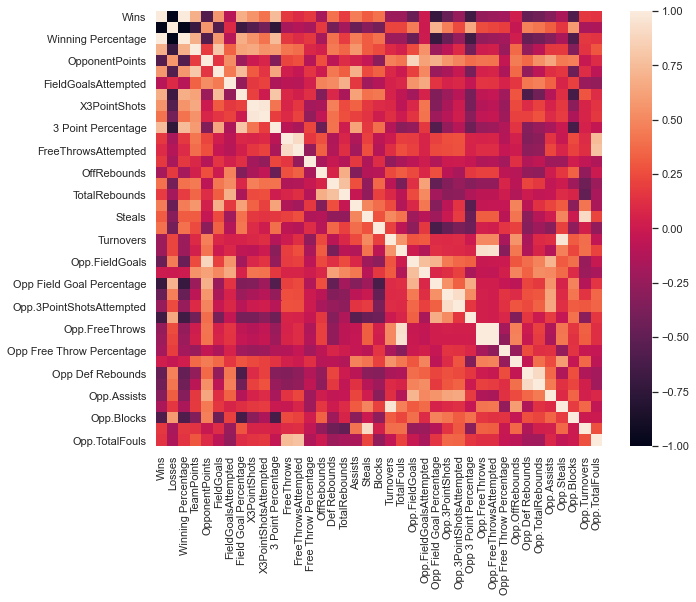

In [15]:
plt.figure(figsize = (10, 8))
sns.heatmap(corr_matrix)

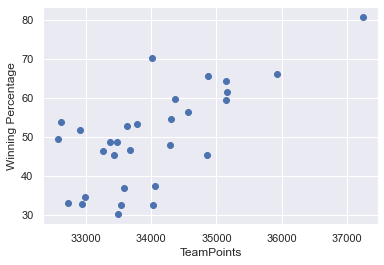

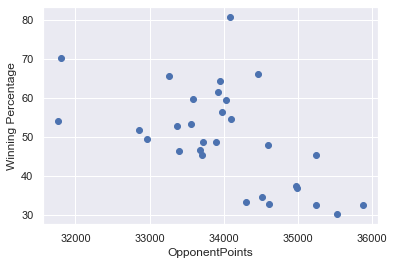

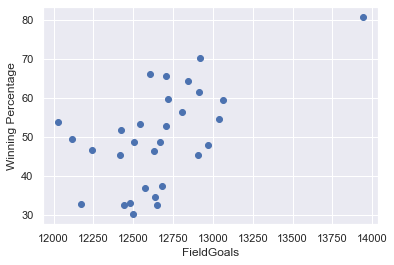

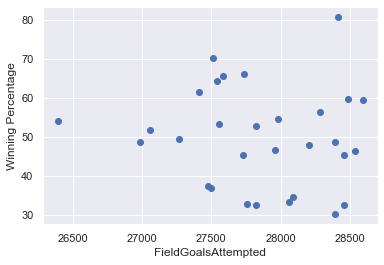

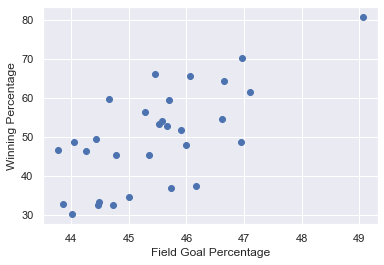

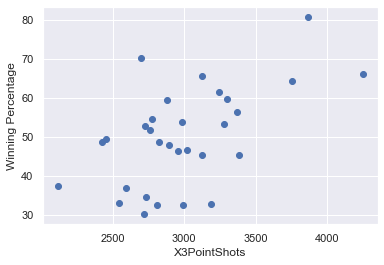

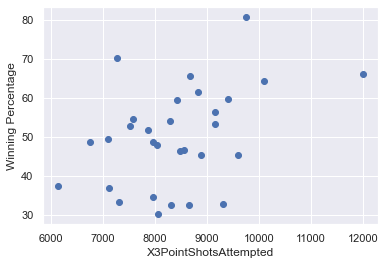

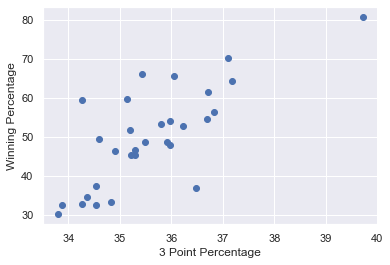

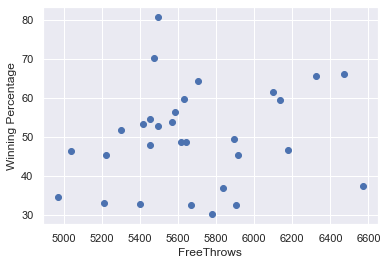

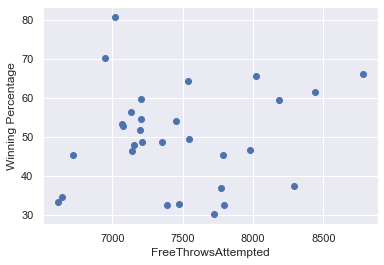

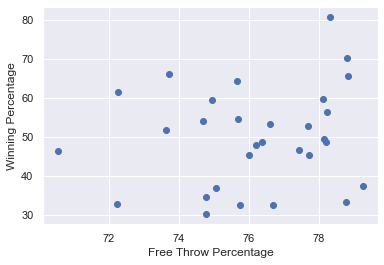

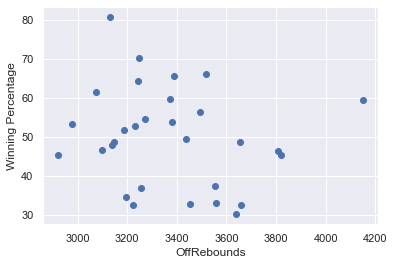

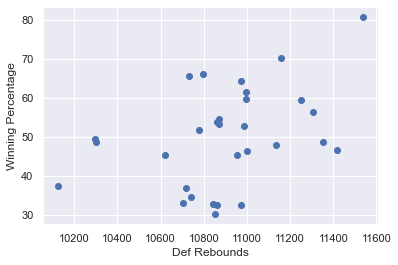

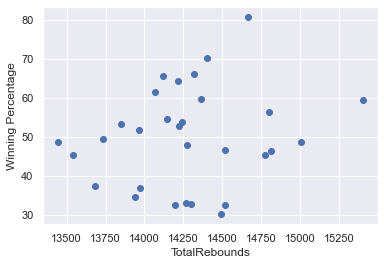

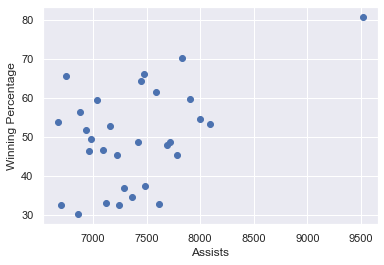

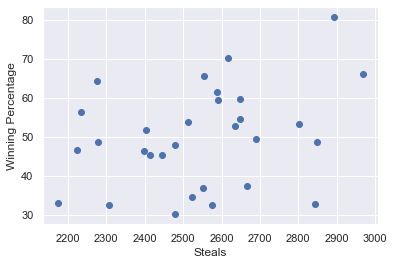

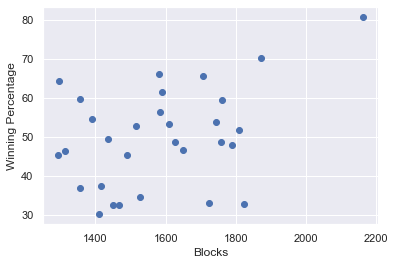

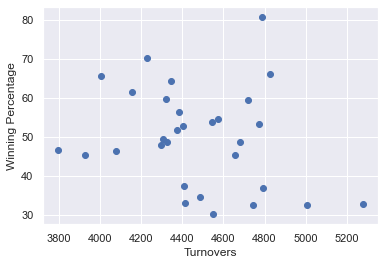

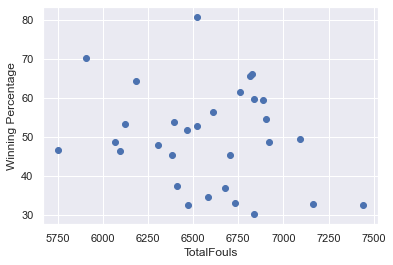

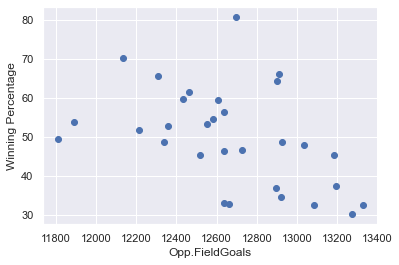

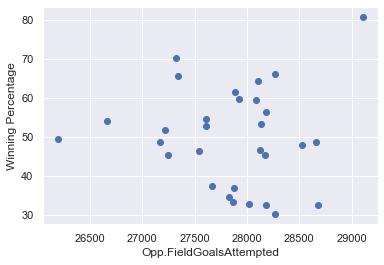

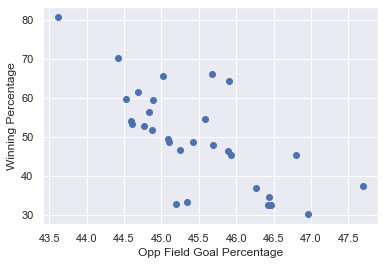

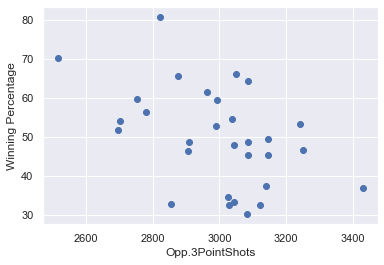

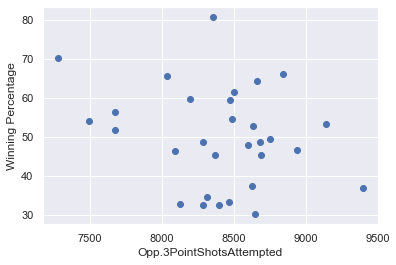

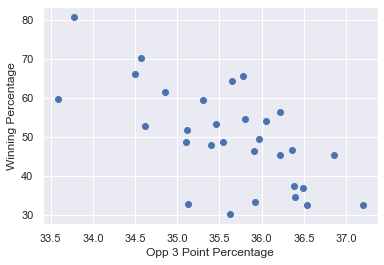

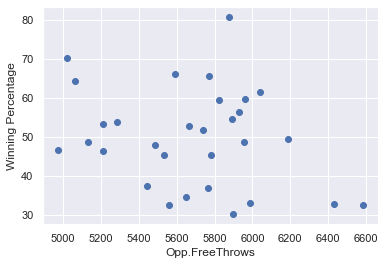

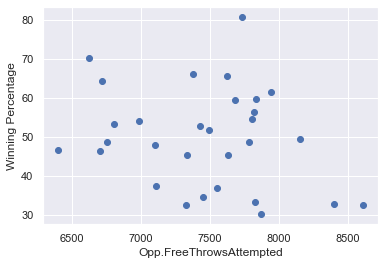

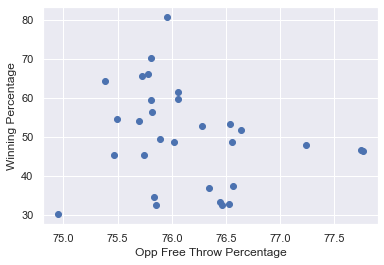

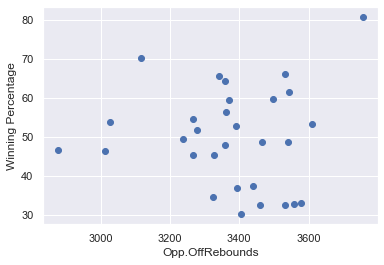

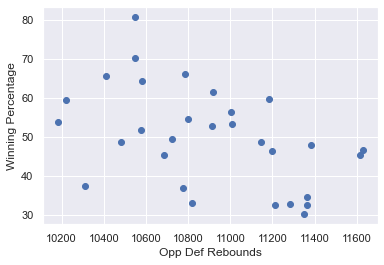

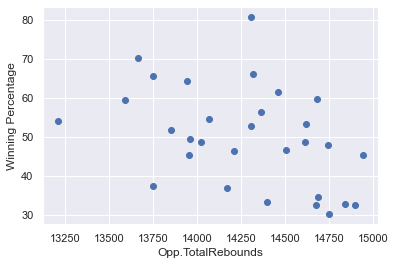

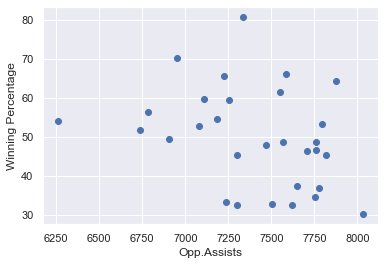

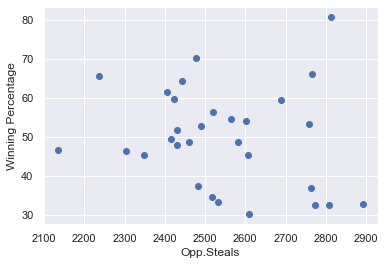

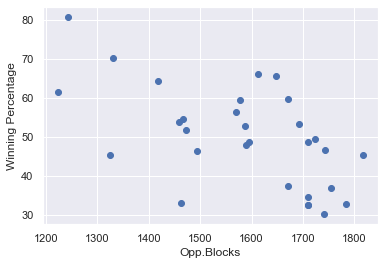

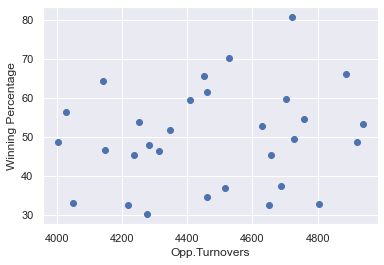

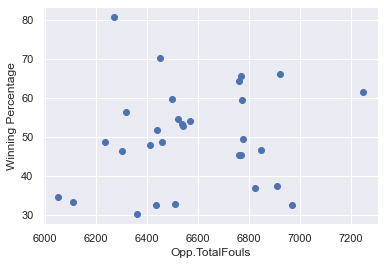

In [16]:
statsNBA = dfNBA.iloc[:, 3:]

for col in statsNBA:
    plt.scatter(dfNBA[col], dfNBA['Winning Percentage'])
    plt.xlabel(col)
    plt.ylabel("Winning Percentage")
    plt.show()

## Simple Linear Regression

In [17]:
model3PT = smf.ols(
    formula='Q("Winning Percentage") ~ Q("3 Point Percentage")', 
    data = dfNBA
).fit()

model3PT.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     Q("Winning Percentage")   R-squared:                       0.570
Model:                                 OLS   Adj. R-squared:                  0.554
Method:                      Least Squares   F-statistic:                     37.05
Date:                     Mon, 02 May 2022   Prob (F-statistic):           1.45e-06
Time:                             14:40:08   Log-Likelihood:                -105.69
No. Observations:                       30   AIC:                             215.4
Df Residuals:                           28   BIC:                             218.2
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                -228.0825     45.715     -4.989      0.000    -321.725    -134.440
Q("3 Point Percentage")     7.8140      1.284      6.086      0.000       5.184      10.444
==============================================================================
Omnibus:                        2.731   Durbin-Watson:                   2.352
Prob(Omnibus):                  0.255   Jarque-Bera (JB):                1.416
Skew:                           0.417   Prob(JB):                        0.493
Kurtosis:                       3.661   Cond. No.                     1.05e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.05e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [18]:
predictors = []
top_preds = []
r2 = []

simpReg = pd.DataFrame()
equation = 'Q("Winning Percentage") ~ Q("'

for col in statsNBA:
    algorithm = equation + col + '")'
    model = smf.ols(formula = algorithm, data = dfNBA).fit()

    predictors.append(col)
    r2.append(model.rsquared)
    
simpReg['Predictor'] = predictors
simpReg['R-Squared'] = r2
simpReg = simpReg.sort_values('R-Squared', ascending = False)

top_preds.append(simpReg['Predictor'].iloc[0])
equation += top_preds[0] + '")'

simpReg

,Predictor,R-Squared
7,3 Point Percentage,0.569529
21,Opp Field Goal Percentage,0.496385
0,TeamPoints,0.477519
4,Field Goal Percentage,0.468208
24,Opp 3 Point Percentage,0.433518
33,Opp.Blocks,0.350549
2,FieldGoals,0.325567
1,OpponentPoints,0.319948
5,X3PointShots,0.314967
29,Opp Def Rebounds,0.224306


Text(0, 0.5, 'Winning Percentage')

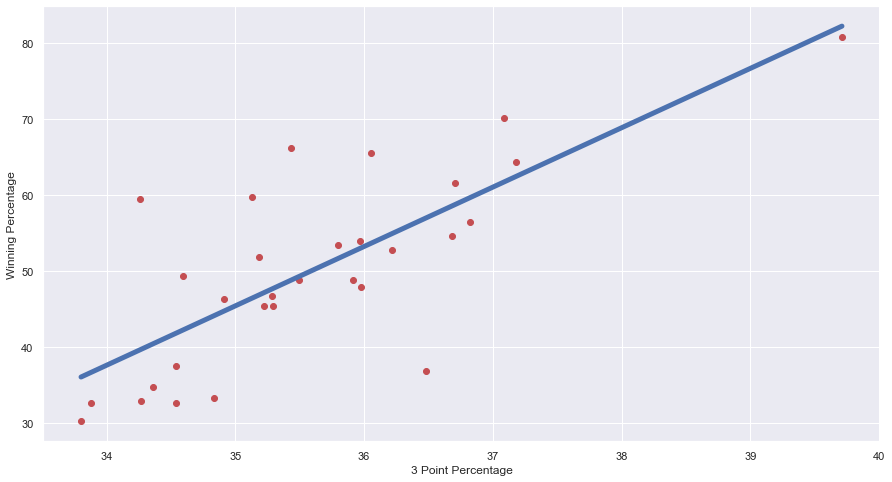

In [19]:
x = dfNBA['3 Point Percentage']
y = dfNBA['Winning Percentage']
beta0, beta1 = model3PT.params

plt.figure(figsize=(15,8))
plt.plot(x, y, 'ro')

xticks = np.linspace(x.min(), x.max())
plt.plot(xticks, beta0 + beta1 * xticks, lw=5)

plt.xlabel('3 Point Percentage')
plt.ylabel('Winning Percentage')

## Multiple Linear Regression

In [20]:
def MultiLine():
    predictors = []
    r2 = []
    reg = pd.DataFrame()

    for col in statsNBA:
        algorithm = equation + ' * Q("' + col + '")'
        model = smf.ols(formula = algorithm, data = dfNBA).fit()

        predictors.append(col)
        r2.append(model.rsquared_adj)

    reg['Predictor'] = predictors
    reg['R-Squared'] = r2
    reg = reg.sort_values('R-Squared', ascending = False)

    return reg

In [21]:
formulas = [equation]

multiReg = pd.DataFrame(columns = ['Predictor', 'R-Squared'])
multiReg.loc[multiReg.shape[0]] = simpReg.iloc[0]

for i in range(4):
    reg = MultiLine()
    
    top_preds.append(reg['Predictor'].iloc[0])
    equation += ' * Q("' + top_preds[-1] + '")'
    
    formulas.append(equation)
    multiReg.loc[multiReg.shape[0]] = reg.iloc[0]

multiReg

,Predictor,R-Squared
0,3 Point Percentage,0.569529
1,Opp 3 Point Percentage,0.669360
2,Opp.TotalRebounds,0.763814
3,X3PointShotsAttempted,0.886375
4,Opp.Turnovers,0.984684


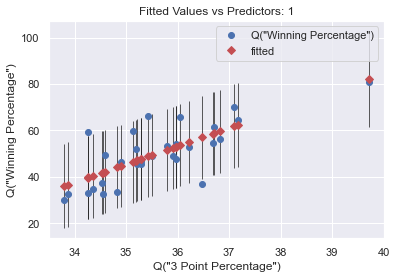

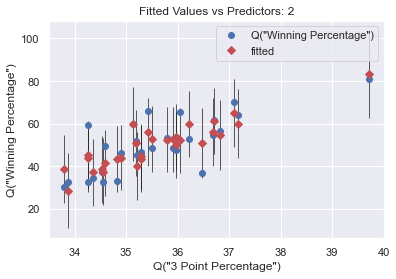

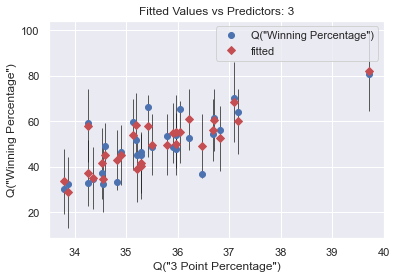

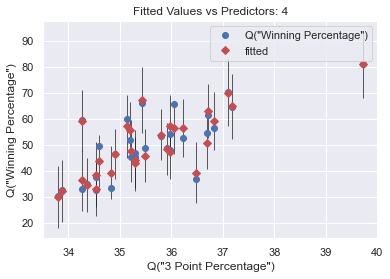

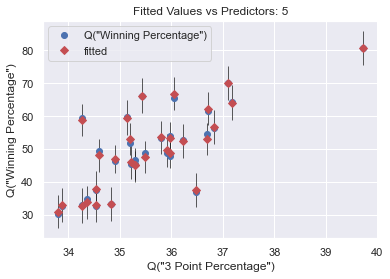

In [22]:
for i in range(len(formulas)):
    fitModel = smf.ols(formula = formulas[i], data = dfNBA).fit()
    sm.graphics.plot_fit(fitModel, 1)
    
    plt.title('Fitted Values vs Predictors: ' + str(i + 1))
    plt.show()

## Logistic Classification

In [23]:
def LogModel(stat, mod, dataset):
    column = '0 + Q("' + stat + '")'
    X = patsy.dmatrix(column, data = dataset)

    return mod.fit(X, dataset['Wins']), X

In [24]:
lr = LogisticRegressionCV()
pred_score = {}

for stat in cleanNBA.iloc[:, 1:]:
    default_mod, X = LogModel(stat, lr, cleanNBA)
    pred_score[stat] = default_mod.score(X, cleanNBA['Wins'])
    
logNBA = pd.DataFrame(pred_score.items(), columns = ['Predictor', 'Score'])
logNBA = logNBA.sort_values('Score', ascending = False)

logNBA

,Predictor,Score
0,TeamPoints,0.696646
3,Field Goal Percentage,0.686280
1,FieldGoals,0.666463
11,Def Rebounds,0.647561
6,3 Point Percentage,0.631606
13,Assists,0.630894
12,TotalRebounds,0.611077
4,X3PointShots,0.597866
15,Blocks,0.571646
7,FreeThrows,0.560163


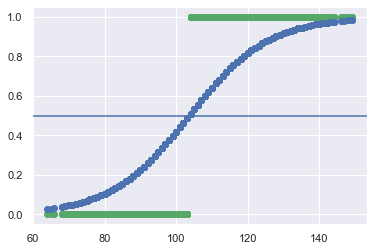

In [25]:
topModel, X = LogModel(logNBA['Predictor'].iloc[0], lr, cleanNBA)

yhat = topModel.predict(X)
yhat_p = topModel.predict_proba(X)

plt.plot(X,yhat,'go');
plt.plot(X,yhat_p[:,1],'bo');
plt.axhline(0.5);

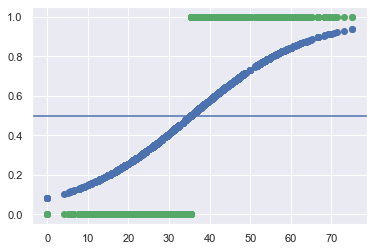

In [26]:
model3PT, X = LogModel('3 Point Percentage', lr, cleanNBA)

yhat = model3PT.predict(X)
yhat_p = model3PT.predict_proba(X)

plt.plot(X,yhat,'go');
plt.plot(X,yhat_p[:,1],'bo');
plt.axhline(0.5);

## K-Nearest Neighbors

In [27]:
def KNN(pred):
    k_scores = {}

    for k in range(1, cleanNBA.shape[1]):
        if k % 2 != 0:
            clf = KNeighborsClassifier(n_neighbors=k, weights='uniform')
            knn_NBA, X = LogModel(pred, clf, cleanNBA)
            k_scores[k] = knn_NBA.score(X, cleanNBA['Wins'])

    df_knn = pd.DataFrame()
    df_knn['K'] = k_scores.keys()
    df_knn['Score'] = k_scores.values()

    df_knn = df_knn.sort_values('Score', ascending = False)
    return df_knn

In [28]:
dfKNN = pd.DataFrame(columns = ['K', 'Score'])

for pred in logNBA['Predictor'].head():
    k_Model = KNN(pred)
    dfKNN.loc[dfKNN.shape[0]] = k_Model.iloc[0]
    
dfKNN.insert(0, 'Predictor', list(logNBA['Predictor'].head()))
dfKNN['K'] = dfKNN['K'].astype('int')
dfKNN = dfKNN.sort_values('Score', ascending = False)

dfKNN

,Predictor,K,Score
1,Field Goal Percentage,17,0.695122
0,TeamPoints,5,0.672459
2,FieldGoals,17,0.658028
3,Def Rebounds,7,0.622358
4,3 Point Percentage,17,0.622154


## Test Modeling

In [29]:
test = []

for i in range(10000):
    test.append(np.random.choice(nba.index))
    
testNBA = nba.loc[test]
testData = buildDB(testNBA)

testData

,Wins,Losses,Winning Percentage,TeamPoints,OpponentPoints,FieldGoals,FieldGoalsAttempted,Field Goal Percentage,X3PointShots,X3PointShotsAttempted,...,Opp.FreeThrowsAttempted,Opp Free Throw Percentage,Opp.OffRebounds,Opp Def Rebounds,Opp.TotalRebounds,Opp.Assists,Opp.Steals,Opp.Blocks,Opp.Turnovers,Opp.TotalFouls
Team,,,,,,,,,,,,,,,,,,,,,
ATL,169,159,51.524390,33352,33345,12465,27529,45.279523,3197,9100,...,6799,76.864245,3612,11076,14688,7762,2741,1746,5003,6438
BOS,190,119,61.488673,32534,31680,12011,26961,44.549535,3068,8861,...,7381,75.802737,3171,10568,13739,6728,2245,1597,4481,6193
BRK,117,251,31.793478,37537,39761,13961,31149,44.820058,3372,9765,...,8201,75.941958,4084,12781,16865,8630,2975,1968,4714,7128
CHI,171,169,50.294118,34631,34956,13028,29608,44.001621,2774,8031,...,7011,76.379974,3657,11580,15237,7803,2514,1761,4148,6421
CHO,154,179,46.246246,33961,34002,12282,28455,43.162889,3041,8655,...,6647,77.237852,2959,11979,14938,7664,2125,1797,4165,7020
CLE,215,118,64.564565,35692,34563,13022,28036,46.447425,3787,10219,...,6905,75.901521,3383,10801,14184,8036,2438,1466,4169,6996
DAL,155,183,45.857988,34457,34611,12732,28465,44.728614,3513,9874,...,7492,75.253604,3484,11861,15345,7555,2408,1301,4868,6993
DEN,155,186,45.454545,36610,36812,13611,29721,45.795902,3469,9543,...,7812,76.587302,3297,10954,14251,8041,2724,1917,4274,6861
DET,174,190,47.802198,37010,36819,14094,31574,44.637993,3275,9295,...,7359,77.225166,3315,12291,15606,8452,2544,1647,4887,6992


In [30]:
cleanTest = CleanData(testNBA)
cleanTest

,Wins,TeamPoints,FieldGoals,FieldGoalsAttempted,Field Goal Percentage,X3PointShots,X3PointShotsAttempted,3 Point Percentage,FreeThrows,FreeThrowsAttempted,Free Throw Percentage,OffRebounds,Def Rebounds,TotalRebounds,Assists,Steals,Blocks,Turnovers,TotalFouls
Team,,,,,,,,,,,,,,,,,,,
LAL,1,132,48,86,55.813953,16,36,44.444444,20,25,80.000000,6,43,49,32,13,6,18,25
BRK,0,99,37,82,45.121951,9,29,31.034483,16,23,69.565217,5,33,38,20,7,8,11,18
WAS,0,106,34,92,36.956522,10,30,33.333333,28,32,87.500000,15,30,45,23,8,6,11,21
IND,0,126,48,82,58.536585,9,20,45.000000,21,30,70.000000,9,24,33,27,10,6,15,29
PHO,0,92,33,82,40.243902,5,22,22.727273,21,27,77.777778,6,32,38,12,7,2,9,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MIA,0,97,37,84,44.047619,10,31,32.258065,13,20,65.000000,8,34,42,24,7,5,15,19
DAL,1,113,40,86,46.511628,10,26,38.461538,23,28,82.142857,15,36,51,22,10,4,11,19
DET,0,95,30,85,35.294118,15,37,40.540541,20,23,86.956522,17,28,45,23,7,3,16,20


In [31]:
dfTest = pd.DataFrame()
r2 = []

for form in formulas:
    model = smf.ols(formula = form, data = testData).fit()
    r2.append(model.rsquared_adj)
    
dfTest['Predictor'] = multiReg['Predictor']
dfTest['Training Score'] = multiReg['R-Squared']
dfTest['Test Score'] = r2

dfTest

,Predictor,Training Score,Test Score
0,3 Point Percentage,0.569529,0.487985
1,Opp 3 Point Percentage,0.669360,0.590487
2,Opp.TotalRebounds,0.763814,0.609123
3,X3PointShotsAttempted,0.886375,0.700893
4,Opp.Turnovers,0.984684,0.712453


In [32]:
def Graph(x_Axis, dataframe):
    plt.figure(figsize=(12,6))

    plt.plot(x_Axis, dataframe['Training Score'], label='Training Data')
    plt.plot(x_Axis, dataframe['Test Score'], 'ro', label='Test Data')

    plt.vlines(
        x_Axis,
        ymin = dataframe['Training Score'], 
        ymax = dataframe['Test Score'],
        color = 'red',
        linestyle = 'dashed'
    )

    plt.legend()

Text(0, 0.5, 'R-Squared Score')

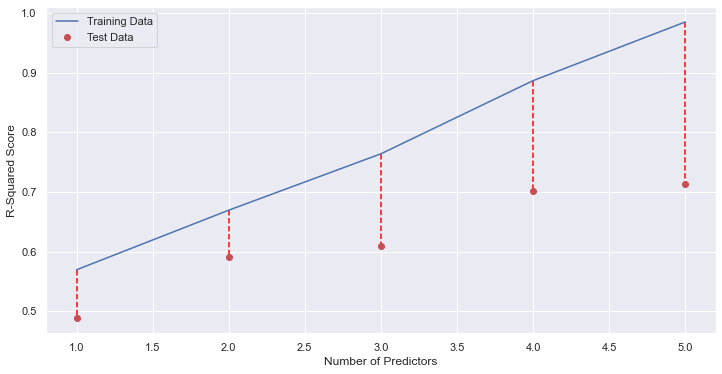

In [33]:
numPreds = range(1, len(dfTest) + 1)
Graph(numPreds, dfTest)

plt.xlabel('Number of Predictors')
plt.ylabel('R-Squared Score')

In [34]:
knnTest = pd.DataFrame(dfKNN)
testScores = []

for i in dfKNN.index:
    k = dfKNN['K'].loc[i]
    pred = dfKNN['Predictor'].loc[i]
    
    clf = KNeighborsClassifier(n_neighbors=k, weights='uniform')
    knn_NBA, X = LogModel(pred, clf, cleanTest)
    testScores.append(knn_NBA.score(X, cleanTest['Wins']))
    
knnTest = knnTest.rename(columns={'Score': 'Training Score'})
knnTest['Test Score'] = testScores

knnTest

,Predictor,K,Training Score,Test Score
1,Field Goal Percentage,17,0.695122,0.7067
0,TeamPoints,5,0.672459,0.6514
2,FieldGoals,17,0.658028,0.6513
3,Def Rebounds,7,0.622358,0.6331
4,3 Point Percentage,17,0.622154,0.6173


Text(0, 0.5, 'KNN Score')

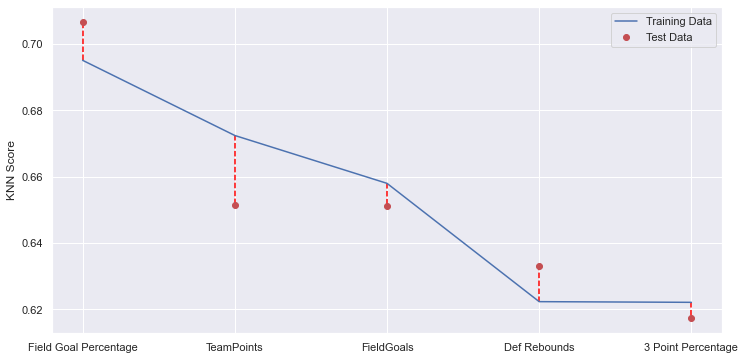

In [35]:
k_Preds = dfKNN['Predictor']
Graph(k_Preds, knnTest)
plt.ylabel('KNN Score')